# Trading Strategies

# Trading signals

## What are trading signals?
First, let's discuss trading signals. Trading signals are **triggers** to long (buy) or short (sell) financial assets based on predetermined criteria. They can be constructed using one technical indicator, multiple technical indicators, or a combination of market data and indicators. Trading signals are commonly used in algorithmic trading, where trading strategies make decisions based on quantitative rules, and remove human discretion.

## A signal example
Here is an example of a simple signal. It is constructed by comparing the price with its n-period simple moving average, or SMA. A long signal is triggered to buy the asset when its price rises above the SMA, and exit the long trade when its price drops below the SMA.

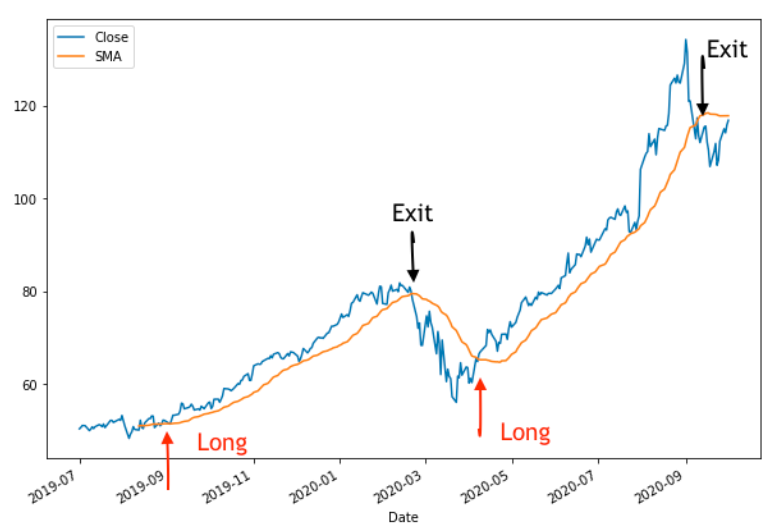

## How to implement signals in bt
Previously (chapter 1), we discussed the 4-step process of defining and backtest trading strategies, and in particular, how bt uses individual algos as building blocks to handle trading logic. 

4-step process:
1. Get the data and calculate indicators
2. Define the signal-based strategy
3. Create and run a backtest
4. Review the backtest result

There are two main ways to implement signals in bt strategies. 

* One way is to use algos.SelectWhere() to filter price levels for constructing the signal, which we will learn more about in this lesson. 
* Another way is to use algos.WeighTarget(), which we will learn more about later.

## Construct the signal
Let's build a signal based strategy with bt step by step using the price and SMA based signal previously mentioned as an example. First, we need to obtain the price data and calculate the moving average indicator. Here we use bt dot get to download the stock price data directly online. To calculate the SMA, we can apply dot rolling dot mean to the price data. Alternatively, we can use the talib library's SMA function.

In [1]:
import bt

# get data
price_data = bt.get('aapl', start='2019-11-1', end='2020-12-1')

In [2]:
# Calculate SMA
sma = price_data.rolling(20).mean()

## Define a signal-based strategy
Now let's apply the signal to the strategy. This is handled by **algos.SelectWhere()**. It takes the argument price larger than SMA, which essentially is a Boolean DataFrame containing selection logic. If the condition is true, that is the price rises above the SMA, a long signal is triggered to enter long positions of the asset. 

There are a few simplifications to this strategy that are worth noting:
* First, we will use the strategy for **trading one asset, or one stock at a time**. When you are trading multiple stocks or assets, their price correlations are important to consider for proper position sizing and asset allocation. This is beyond the scope of this course. 
* Another simplification we make is to assume there is **no slippage or commission in the trade execution**. 
    * **Slippage** is the difference between the expected price of a trade and the price at which the trade is executed, and often occurs when there is a supply and demand imbalance. 
    * **Commissions** are fees charged by brokers when executing a trade. These are practical considerations in real trading, but for now we will focus on the basics.

## Backtest the signal based strategy
Once we have the strategy defined, let's create and run a backtest and to see how it performs.

In [3]:
bt_strategy = bt.Strategy('AboveEMA',
                          [bt.algos.SelectWhere(price_data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

bt_backtest = bt.Backtest(bt_strategy, price_data)
bt_result = bt.run(bt_backtest)


## Plot the backtest result
Last, let's plot and review the backtest result. 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

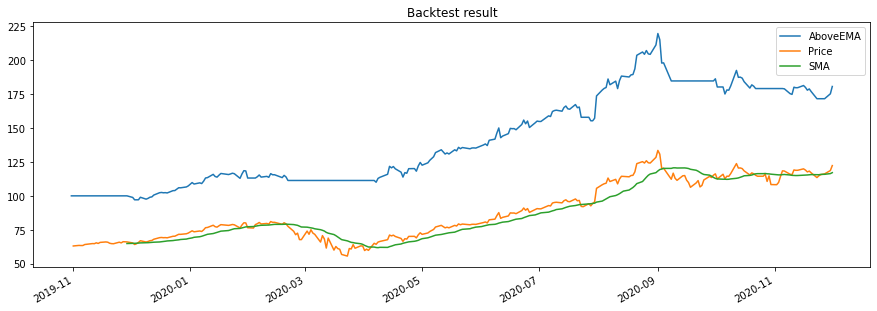

In [5]:
bt_result.plot(title='Backtest result')
plt.plot(price_data, label='Price')
plt.plot(sma, label='SMA')
plt.legend()
plt.show()

The line chart shows how much the beginning capital balance increases over time from a baseline of 100. 

**Note the flat line areas** indicate periods when we don't have any positions, so the trading account balance does not change. Overall, **the strategy is profitable** based on the backtest performed on the historical data.

# Two types of trading strategies

The two most popular types of trading strategies are **trend following** and **mean reversion**. 

* **Trend following**, also known as a momentum strategy, **bets that the price trend will continue in the same direction**. You implemented a simple trend-following strategy in the previous lesson. When the price rises above its moving average, enter a long position to bet the price will continue to rise. Traders commonly use trend indicators such as **moving averages, ADX, etc** to construct trading signals for trend following strategies. 
* **Mean reversion** strategies, conversely, **bet that when the market reaches an overbought or oversold condition**, the price tends to reverse back towards the mean. We will learn more about them in the following lesson. Traders commonly use indicators such as **RSI, Bollinger Bands, etc,** to construct trading signals for mean-reversion strategies. 

Markets are constantly moving in and out of phases of trending and mean reversion. Therefore it's beneficial to develop strategies for both phases.

## Trend-following strategies - MA crossover strategy
The philosophy of trend following strategy is: the trend is your friend. Let's look at a common example of a trend-following strategy called MA (moving average) crossover, which involves two moving average indicators, one longer and one shorter. We will use the EMA for example. 

* **long signal**: When the short-term EMA crosses above the long-term EMA, as it suggests the price is picking up momentum. 

* **short signal**: When the short-term EMA crosses below the long-term EMA, as it suggests that the price is losing momentum.

## Calculate the indicators
First, let's calculate the indicators with the talib EMA function. Note we use to underscore frame to save the result as a pandas DataFrame.

In [6]:
import talib

In [7]:
EMA_short = talib.EMA(price_data['aapl'],
                      timeperiod=10).to_frame() # to.frame() is used to convert result to pandas dataframe
EMA_long = talib.EMA(price_data['aapl'],
                     timeperiod=40).to_frame()

## Construct the signal
1. We construct the signal by **copying the EMA indicator DataFrame** with the .copy() method. 
1. We set the **signal value to 0** for the initial n periods that do not have enough data points for the EMA. 
1. Then, we **define the signal**. When the short-term EMA value is larger than the long-term EMA value, the signal is one indicating a long position; when short-term EMA is smaller than the long-term EMA, the signal is minus one indicating a short position. Note that shorting a stock essentially means betting the price will go down, and entails selling borrowed shares, and later buying them back at market price.

In [8]:
# Create the signals DF
signal = EMA_long.copy()
signal[EMA_long.isnull()] = 0

# Define the signal
signal[EMA_short > EMA_long] = 1
signal[EMA_short < EMA_long] = -1

## Plot the signal
We can plot the signal with the price and EMA indicators together. 

1. First use bt **merge to combine multiple DataFrames**. It takes in several DataFrames and merges them into one based on the DataFrame index, in this case the Date. 
2. Then use the .columns attribute of the DataFrame to **rename the data columns and create a plot**. 
3. Since the signal has a different scale from the price and EMA data, **define secondary underscore y to the signal column to plot it on secondary y axis on the right**. The chart gives a clear indication of where to take long or short positions.

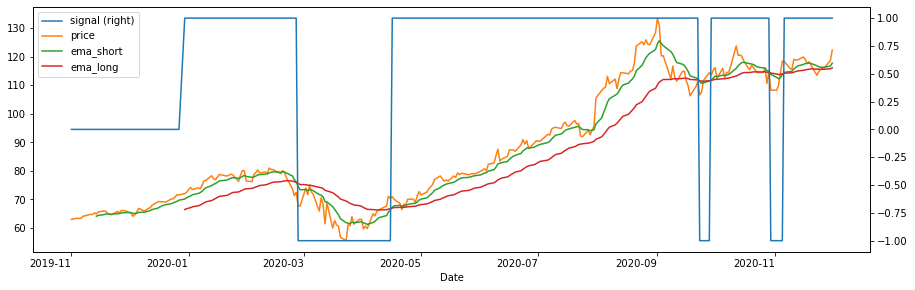

In [9]:
combined_df = bt.merge(signal, price_data, EMA_short, EMA_long)
combined_df.columns = ['signal', 'price', 'ema_short', 'ema_long']
combined_df.plot(secondary_y=['signal'], figsize=(15,5), rot=0)
plt.show()

## Define the strategy with the signal
Now we are ready to implement the signal in the strategy. In the previous lesson, we used algos.SelectWhere() to build the signal. Here the signal is not constructed directly from the price comparison, so we will use another way provided by **bt.Call.WeighTarget()** and pass the signal DataFrame. 

The signal value 1, -1 or 0 will dictate which period we will have long positions, short positions, or no positions.

In [10]:
signal.columns = ['aapl'] # adjusting the column name because it needs to be same as price_data column name
bt_strategy = bt.Strategy('EMA_crossover',
                          [bt.algos.WeighTarget(signal),
                           bt.algos.Rebalance()])

## Backtest the signal based strategy
Once we have the strategy defined, create and run a backtest and see how it performs.

In [11]:
bt_backtest = bt.Backtest(bt_strategy, price_data)
bt_result = bt.run(bt_backtest)

## Plot backtest results
Last, let's plot and review the backtest result. Overall the strategy is profitable based on the historical period backtested.

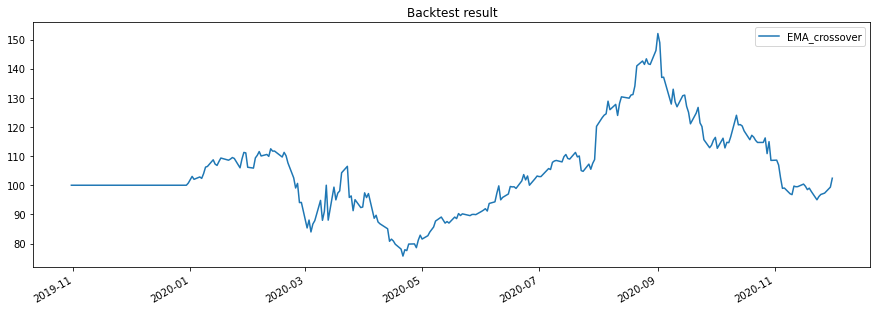

In [13]:
bt_result.plot(title='Backtest result')
plt.show()

# Mean reversion strategy

## RSI-based mean reversion strategy
The philosophy of mean reversion strategy is: **buy the fear and sell the greed**. Or put it more plainly: **buy the dip and sell the peak**. Let's look at an example of a mean-reversion strategy involving the RSI indicator. 

* **short signal**: When the RSI rises to a relatively high value, 70 for example, as it suggests the asset is likely overbought and the price may soon reverse. 
* **long signal**: When the RSI drops to a relatively low value, 30 for example, as it suggests the asset is likely oversold and the price may soon rally.

## Calculate the indicator
First, let's calculate the indicators with the talib RSI function, and save the result as a DataFrame with to_frame().

In [18]:
# Calculate RSI
stock_rsi = talib.RSI(price_data['aapl']).to_frame()
stock_rsi.columns = ['aapl']

## Construct the signal
Then we can construct the signal. First, create a signal DataFrame by copying the RSI indicator DataFrame. 

Let's define: 

* **RSI < 30 -** approaching an oversold condition, so set the signal to **1** to enter a long position. 
* **RSI > 70 -** approaching an overbought condition, so set the signal to **-1** to enter a short position. 
* **30 < RSI < 70 -** set the signal to **0** indicating no trade positions.

In [20]:
# Create same DF structure as RSI 
signal = stock_rsi.copy()
signal[stock_rsi.isnull()] = 0 #imputing nulls

# Construct Signal
signal[stock_rsi < 30] = 1
signal[stock_rsi > 70] = -1
signal[(stock_rsi > 30) & (stock_rsi < 70)] = 0

## Plot the signal
To plot the signal with the price together, use bt.merge() to combine multiple DataFrames, then call .plot(). Note we don't merge the RSI indicator with the price since they are on different scales. Recall in chapter two we learned RSI is bounded between 0 to 100. Instead, we can place the RSI plot along with the signal plot to observe where to take long or short trades based on RSI values.

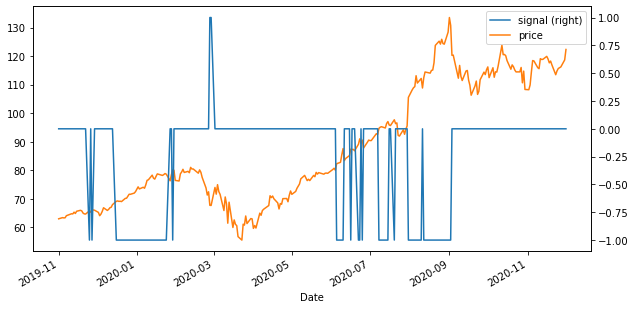

In [29]:
# merge dataframes into 1
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'price']

# Plot the signal with price
combined_df.plot(secondary_y='signal', figsize=(10,5))
plt.show()

## Define the strategy with the signal
Now we are ready to implement the signal in the strategy. Just as in the previous lesson, call algos.WeighTarget() and pass in the signal DataFrame. The signal value will dictate which period will have long positions, short positions, or no positions.

In [30]:
bt_strategy = bt.Strategy('RSI_meanReversion',
                          [bt.algos.WeighTarget(signal),
                           bt.algos.Rebalance()])

## Backtest the signal-based strategy
Once we have the strategy defined, create and run a backtest and see how it performs.

In [31]:
bt_backtest = bt.Backtest(bt_strategy, price_data)
bt_result = bt.run(bt_backtest)

## Plot backtest result
Last, let's plot and review the backtest result. 

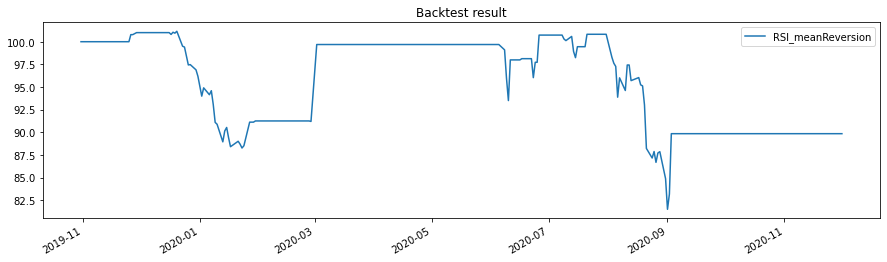

<Figure size 1080x288 with 0 Axes>

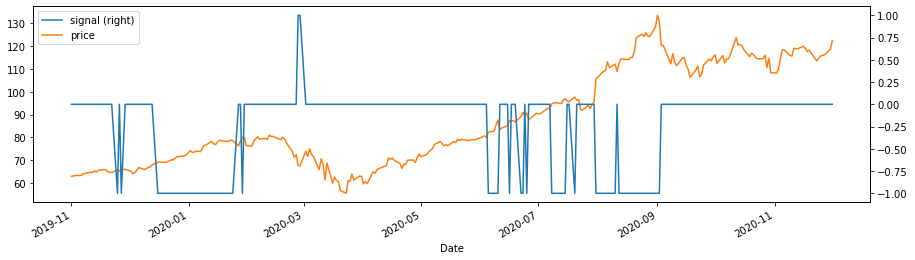

In [54]:
bt_result.plot(title='Backtest result', figsize=(15,4))
plt.figure(figsize=(15,4))
combined_df.plot(secondary_y='signal', figsize=(15,4))
plt.show()

Since the RSI-based mean reversion strategy tries to take advantage of temporary market imbalances, it tends to trade more frequently, Also if the RSI value does not indicate an overbought or oversold market condition, no trade is taken so the profit line is flat. Overall, the strategy is profitable based on the historical period backtested

# Strategy optimization and benchmarking

## How to decide the values of input parameters?
In previous lessons, we have built and backtested several trading strategies. But when implementing a strategy, how do we determine the values of input parameters? For example, when we construct the signal based on the price and SMA comparison, what is the SMA lookback period we should use? Can a 10, 20, or 50-period SMA result in a more profitable strategy? 

The solution is to conduct **strategy optimization**, which is the process of testing a range of input parameter values to find the ones that give better strategy performance based on historical data.

## Strategy optimization example
Let's look at an example of performing strategy optimization. In lesson 1 of this chapter, we implemented a strategy based on a price and SMA comparison. 

To find the SMA lookback period that can optimize the strategy performance, we want to run multiple backtests by varying the SMA timeperiod parameters on different runs. To make the code reusable, we will define a Python function.

Here we define a function **signal_strategy** that packages the process of implementing the strategy. We can pass the period as a parameter to change the SMA lookback period. In addition, we can pass the stock ticker, start date, and end date to run backtests on different stocks and on different historical periods. 

Note that by specifying a value of a parameter in the header, we set a default argument that will be used if an argument is not passed. For example, here we set the start and end parameters with default dates. Within the body of the function, our code can then use the values these parameters take when the function is called. Lastly, we use the return keyword to return the backtest whenever the function is called.

In [55]:
# Defining signal_strength
def signal_strength(ticker, name, period=14, start='2018-4-1', end=None):
    # get data and calculate SMA
    price_data = bt.get(ticker, start=start, end=end)
    sma = price_data.rolling(period).mean()
    
    # define the signal based strategy
    bt_strategy = bt.Strategy(name,
                              [bt.algos.SelectWhere(price_data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
    # Return Backtest
    return bt.Backtest(bt_strategy, price_data)

## Strategy optimization example
Then we can call the function several times to pass different SMA lookback parameters. Each function will return a bt Backtest. Call bt dot run to run all the Backtests at once, and plot the results in one chart for easy comparison. 

In [64]:
ticker = 'aapl'
sma20 = signal_strength(ticker, period=20, name='SMA_20')
sma50 = signal_strength(ticker, period=50, name='SMA_50')
sma100 = signal_strength(ticker, period=100, name='SMA_100')


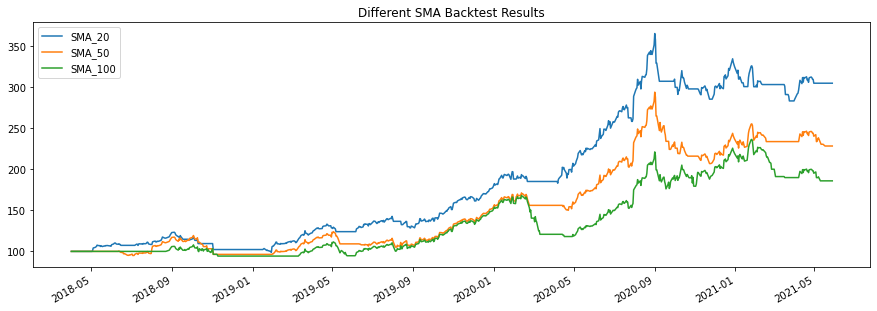

In [65]:
bt_results = bt.run(sma20, sma50, sma100)
bt_results.plot(title='Different SMA Backtest Results')
plt.show()

From the chart we can see using the 20-period SMA gives us the most profitable strategy based on the historical period backtested.

## What is a benchmark?
A **benchmark is a standard or point of reference** against which a strategy can be compared or assessed. For example, a strategy that uses signals to actively trade stocks can use a passive buy and hold strategy as a benchmark. A benchmark can also be chosen based on the market segments and asset risk profiles. For example, the S&P 500 index is often used as a benchmark for US equity performance, and US Treasuries are used for measuring bond risks and returns.

## Benchmarking example
Continue the previous example, let's define a benchmark. Instead of using a signal-based strategy to actively trade a stock, we will passively hold the stock and use its performance as the benchmark. Define a separate function to describe the benchmark. Use **bt.algos.RunOnce()** to implement a passive strategy, that is buy a stock at the beginning of the period and just hold until the end of the period.

In [66]:
def buy_and_hold(ticker, name, start='2010-11-1', end=None):
    # get data
    price_data = bt.get(ticker, start=start, end=end)
    bt_strategy = bt.Strategy(name, 
                              [bt.algos.RunOnce(),
                               bt.algos.SelectAll(),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
    return bt.Backtest(bt_strategy, price_data)

## Benchmarking example
Then call the function to create a bt.Backtest(). Similarly, we can use bt.run() to run multiple backtests and plot their results together. The results look interesting. They suggest some active strategies outperformed the benchmark whereas some underperformed.

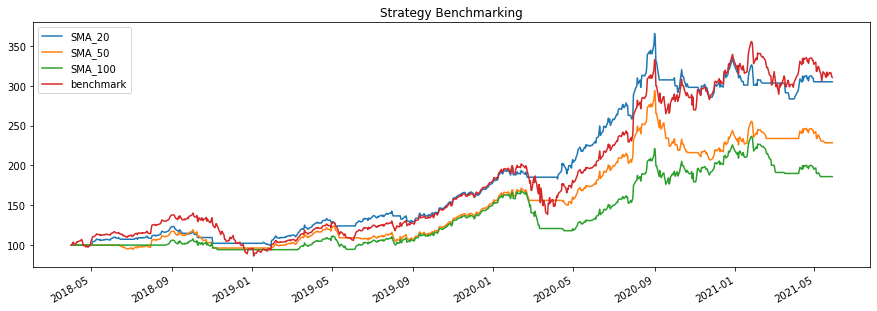

In [68]:
benchmark = buy_and_hold(ticker, name='benchmark')
bt_results = bt.run(sma20, sma50, sma100, benchmark)
bt_results.plot(title='Strategy Benchmarking')
plt.show()